In [6]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install matplotlib==3.1.3
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3-2048.gwf

# -- for gwpy 
#from gwpy.timeseries import TimeSeries
#gwpy_strain = TimeSeries.read('challenge3-2048.gwf', channel="H1:CHALLENGE3")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3-2048.gwf', 'H1:CHALLENGE3')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gwpy 3.0.2 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
--2023-01-05 03:47:19--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3-2048.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128413794 (122M)
Saving to: ‘challenge3-2048.gwf.2’

challenge3-204

[-2.97645347e-19 -2.41441612e-19 -2.45994841e-19 ...
  4.43758152e-19  3.05906389e-19  3.18195394e-20]
The type of gwpy_strain is  <class 'pycbc.types.timeseries.TimeSeries'>


(8, 10)

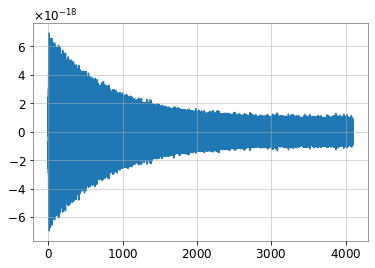

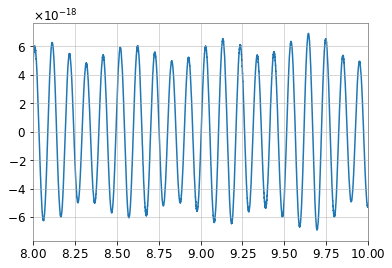

In [13]:
#%matplotlib inline

import pylab

print(pycbc_strain)
print('The type of gwpy_strain is ', type(pycbc_strain))

pylab.figure()
pylab.plot(pycbc_strain.sample_times,pycbc_strain)

#Adjusting time

pylab.figure(2)
pylab.plot(pycbc_strain.sample_times, pycbc_strain)
pylab.xlim(8,10)


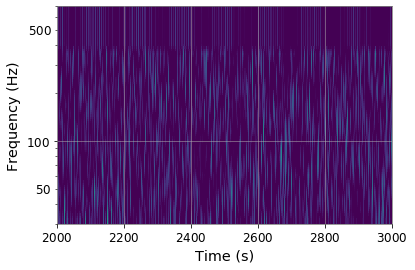

In [19]:
t, f, p = pycbc_strain.qtransform(.01, logfsteps=100, qrange=(8, 8), frange=(30, 700))
pylab.figure()
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.xlim(2000, 3000)
pylab.show()

Text(0, 0.5, 'Amplitude')

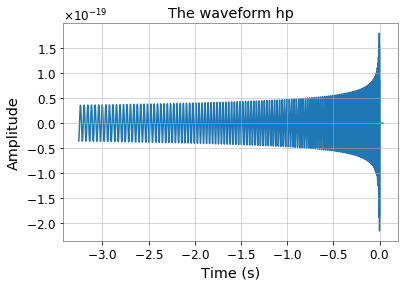

In [14]:
#Template
from pycbc.waveform import get_td_waveform
hp,hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=20,
                         mass2=20,
                         delta_t=pycbc_strain.delta_t,
                         f_lower=25)

pylab.figure()
pylab.title("The waveform hp")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Amplitude')

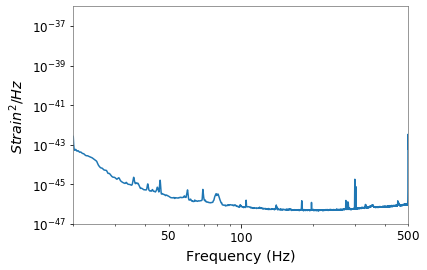

In [17]:
#This is the data
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = pycbc_strain.psd(4)

psd = interpolate(psd, pycbc_strain.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * pycbc_strain.sample_rate), low_frequency_cutoff=20)

pylab.plot(psd.sample_frequencies, psd)
pylab.yscale('log')
pylab.xscale('log')
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(20,1000)
pylab.ylim(1e-47, 1e-36)
pylab.grid()
pylab.show()

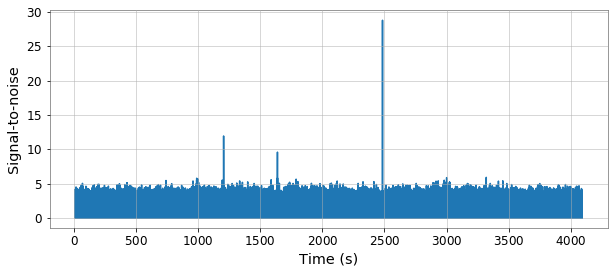

We found a signal at 2483.96728515625s with SNR 28.82629574476008


In [18]:
#SNR
from pycbc.filter import matched_filter

hp.resize(len(pycbc_strain))
template = hp.cyclic_time_shift(hp.start_time)


snr = matched_filter(template, pycbc_strain, psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))